The Code Below Connects to Yahoo Finance API

In [ ]:
# YAHOO
import yfinance as yf

def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock price data from Yahoo Finance API.

    Parameters:
        ticker (str): The stock ticker symbol, e.g., 'AAPL' for Apple Inc.
        start_date (str): The start date for the data in 'YYYY-MM-DD' format.
        end_date (str): The end date for the data in 'YYYY-MM-DD' format.

    Returns:
        pandas.DataFrame: DataFrame containing the stock data with columns for
                          Date, Open, High, Low, Close, Adj Close, and Volume.
    """
    # Use yfinance to download stock data
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    
    # Display the first few rows of the data
    print(stock_data.head())
    return stock_data

# Example usage:
ticker_symbol = "AAPL"  # Example ticker symbol for Apple Inc.
start = "2023-01-01"
end = "2023-12-31"

# Fetch the stock data
apple_stock_data = fetch_stock_data(ticker_symbol, start, end)

[*********************100%***********************]  1 of 1 completed


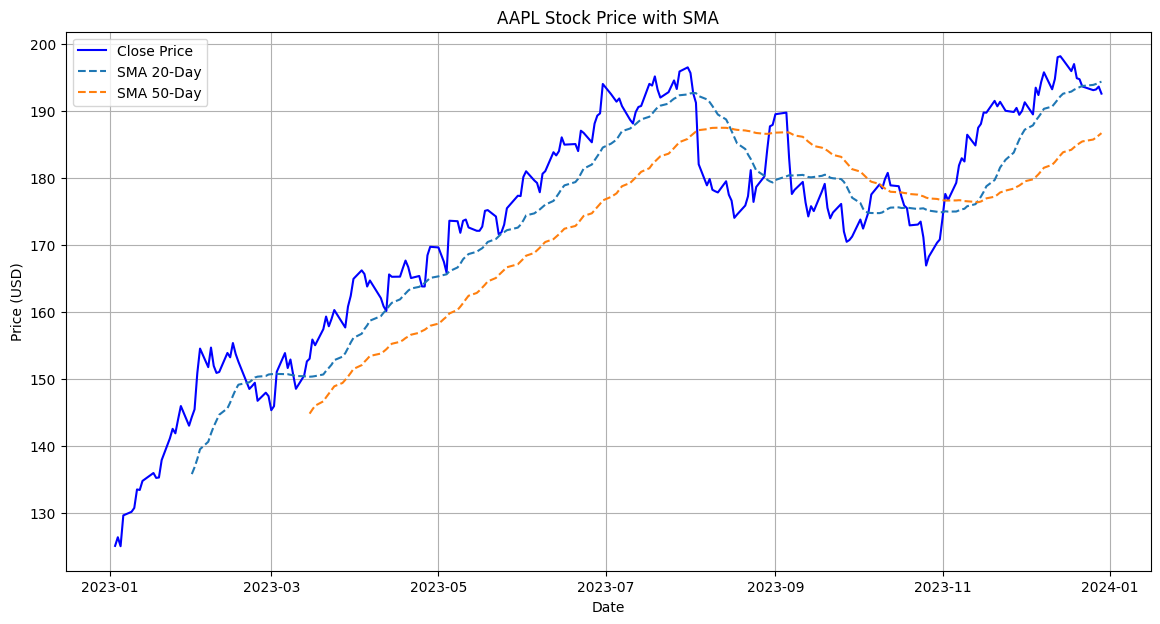

In [12]:
import yfinance as yf
import matplotlib.pyplot as plt

def plot_stock_with_sma(ticker, start_date, end_date, sma_windows=[20, 50]):
    # Download historical data
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    
    # Calculate SMAs for each window size specified in sma_windows
    for window in sma_windows:
        stock_data[f'SMA_{window}'] = stock_data['Close'].rolling(window=window).mean()
    
    # Plot the historical closing price and SMA lines
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data['Close'], label='Close Price', color='blue')
    
    # Plot each SMA
    for window in sma_windows:
        plt.plot(stock_data[f'SMA_{window}'], label=f'SMA {window}-Day', linestyle='--')
    
    # Chart settings
    plt.title(f"{ticker} Stock Price with SMA")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Example Usage
ticker = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'
plot_stock_with_sma(ticker, start_date, end_date, sma_windows=[20, 50])

The Code Below Connect to AlphaVantage APIs

In [ ]:
import requests
import pandas as pd

# Replace with your actual Alpha Vantage API key
API_KEY = 'FGDYAANWX6EFL9PL'
BASE_URL = 'https://www.alphavantage.co/query'

In [5]:
def get_real_time_stock_data(symbol):
    params = {
        'function': 'GLOBAL_QUOTE',
        'symbol': symbol,
        'apikey': API_KEY
    }
    response = requests.get(BASE_URL, params=params)
    data = response.json()
    
    if 'Global Quote' in data:
        return data['Global Quote']
    else:
        return 'Error: No data found for the symbol.'

# Example Usage
symbol = 'AAPL'
real_time_data = get_real_time_stock_data(symbol)
print("Real-Time Stock Data:", real_time_data)


Real-Time Stock Data: {'01. symbol': 'AAPL', '02. open': '225.1200', '03. high': '228.8700', '04. low': '225.0500', '05. price': '228.2200', '06. volume': '44865135', '07. latest trading day': '2024-11-14', '08. previous close': '225.1200', '09. change': '3.1000', '10. change percent': '1.3770%'}


In [9]:
def get_historical_stock_data(symbol, interval='daily'):
    function_map = {
        'daily': 'TIME_SERIES_DAILY_ADJUSTED',
        'weekly': 'TIME_SERIES_WEEKLY',
        'monthly': 'TIME_SERIES_MONTHLY'
    }
    params = {
        'function': function_map.get(interval, 'TIME_SERIES_DAILY_ADJUSTED'),
        'symbol': symbol,
        'apikey': API_KEY,
        'outputsize': 'compact'  # Use 'full' for full history (may be larger)
    }
    response = requests.get(BASE_URL, params=params)
    data = response.json()
    
    # Check for valid response
    time_series_key = 'Time Series (Daily)' if interval == 'daily' else f'Time Series ({interval.title()})'
    if time_series_key in data:
        df = pd.DataFrame.from_dict(data[time_series_key], orient='index')
        df.columns = [col.split('. ')[1] for col in df.columns]
        return df
    else:
        error_message = data.get("Error Message", "Error: No data found for the symbol.")
        return error_message


In [11]:

import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define the list of stock tickers (BTC-USD removed)
tickers = [
    'AAPL', 'GOOGL', 'MSFT', 'ASTS', 'PTON', 'GSAT', 'PLTR', 'SMR', 'ACHR',
    'BWXT', 'ARBK', 'AMD', 'NVDA', 'GME', 'MU', 'TSLA', 'NFLX', 'ZG',
    'AVGO', 'SMCI', 'GLW', 'HAL', 'LMT', 'AMZN', 'CRM', 'NOW', 'CHTR', 'TDS', 'META'
]

# Define the time range
end_date = datetime.today()
start_date = end_date - timedelta(days=60)

# Fetch stock data using yfinance
stock_data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

# Create an empty DataFrame for the reformatted data
reformatted_data = pd.DataFrame()

# Process each ticker to include Close, Volume, and Percent Change
for ticker in tickers:
    if ticker in stock_data.columns.levels[0]:  # Ensure ticker exists in data
        # Use 'Close' for adjusted prices
        temp = stock_data[ticker][["Close", "Volume"]].copy()
        temp.columns = [f"{ticker}_Close", f"{ticker}_Volume"]
        temp[f"{ticker}_PctChange"] = temp[f"{ticker}_Close"].pct_change() * 100  # Calculate % change
        temp["Date"] = temp.index  # Keep the index as the Date column
        
        # Merge the data while keeping the index intact (ensures no weekends or holidays)
        reformatted_data = pd.concat([reformatted_data, temp], axis=1)

# Remove duplicate 'Date' columns and ensure one is at the start
if 'Date' in reformatted_data.columns:
    reformatted_data = reformatted_data.loc[:, ~reformatted_data.columns.duplicated()]
    reformatted_data.reset_index(drop=True, inplace=True)
    columns = ["Date"] + [col for col in reformatted_data.columns if col != "Date"]
    reformatted_data = reformatted_data[columns]

# Save the reformatted data to a CSV file
csv_filename = "all_stocks_data_with_pct_change_filtered.csv"
reformatted_data.to_csv(csv_filename, index=False)

print(f"Data saved to: {csv_filename}")




[*********************100%***********************]  29 of 29 completed


Data saved to: all_stocks_data_with_pct_change_filtered.csv


In [13]:
import yfinance as yf
import pandas as pd
from datetime import datetime

# Define the list of stock tickers
TICKERS = [
    'AAPL', 'GOOGL', 'MSFT', 'ASTS', 'PTON', 'GSAT', 'PLTR', 'SMR', 'ACHR',
    'BWXT', 'ARBK', 'AMD', 'NVDA', 'GME', 'MU', 'TSLA', 'NFLX', 'ZG',
    'AVGO', 'SMCI', 'GLW', 'HAL', 'LMT', 'AMZN', 'CRM', 'NOW', 'CHTR', 'TDS', 'META'
]

# Create a list to store current stock data
stock_data_list = []

for ticker in TICKERS:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info  # Fetch current stock information
        current_data = {
            "Date": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            "Ticker": ticker,
            "Current_Price": info.get("currentPrice"),
            "Open": info.get("open"),
            "High": info.get("dayHigh"),
            "Low": info.get("dayLow"),
            "Volume": info.get("volume"),
            "Market_Cap": info.get("marketCap"),
            "Previous_Close": info.get("previousClose")
        }
        stock_data_list.append(current_data)
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        continue

# Convert list to DataFrame
stock_data_df = pd.DataFrame(stock_data_list)

# Save DataFrame to a local CSV file
output_file = "current_stock_datadddd.csv"
stock_data_df.to_csv(output_file, index=False)

print(f"Current stock data saved to {output_file}.")


Current stock data saved to current_stock_datadddd.csv.
